In [9]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(684)
torch.manual_seed(684)
if device == 'cuda':
    torch.cuda.manual_seed_all(684)

# parameters
training_epochs = 20
batch_size = 256

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# MNIST data image of shape 28 * 28 = 784
linear = torch.nn.Linear(784, 10, bias=True).to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

start = time.time()  # start time
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')
print("time :",time.time() - start)  # Q1) Complete the code to print the total execution time.

Epoch: 0001 cost = 0.712555885
Epoch: 0002 cost = 0.430617332
Epoch: 0003 cost = 0.384914279
Epoch: 0004 cost = 0.361091703
Epoch: 0005 cost = 0.346667796
Epoch: 0006 cost = 0.336117923
Epoch: 0007 cost = 0.328234792
Epoch: 0008 cost = 0.321561575
Epoch: 0009 cost = 0.316711277
Epoch: 0010 cost = 0.312152416
Epoch: 0011 cost = 0.308560967
Epoch: 0012 cost = 0.304768443
Epoch: 0013 cost = 0.302265793
Epoch: 0014 cost = 0.299752086
Epoch: 0015 cost = 0.297287613
Epoch: 0016 cost = 0.295147717
Epoch: 0017 cost = 0.293461204
Epoch: 0018 cost = 0.291673988
Epoch: 0019 cost = 0.290059984
Epoch: 0020 cost = 0.288329512
Learning finished
time : 97.24805188179016


Accuracy: 0.8973999619483948
Label:  2
Prediction:  2


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


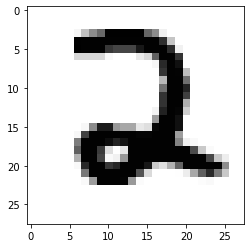

In [11]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Q2) Complete the following code so that read and print one test data of the last 4 digits of your student ID.
    # ex. In case of s_id = 2008710991, read and print 0992th test data sample.
    r = 5385 
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())
    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

In [12]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(0)
if device == 'cuda':
    torch.cuda.manual_seed_all(0)

# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)


# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

# CNN Model (2 conv layers)
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc1 = torch.nn.Linear(3 * 3 * 128, 625, bias=True)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# instantiate CNN model
model = CNN().to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train my model
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.159659967
[Epoch:    2] cost = 0.0422342196
[Epoch:    3] cost = 0.0290623419
[Epoch:    4] cost = 0.0223662648
[Epoch:    5] cost = 0.0172148105
[Epoch:    6] cost = 0.0147868218
[Epoch:    7] cost = 0.0122401342
[Epoch:    8] cost = 0.00917849969
[Epoch:    9] cost = 0.0106467512
[Epoch:   10] cost = 0.00831823703
[Epoch:   11] cost = 0.00850308035
[Epoch:   12] cost = 0.00611991016
[Epoch:   13] cost = 0.00612412859
[Epoch:   14] cost = 0.00457985746
[Epoch:   15] cost = 0.00690642418
Learning Finished!


In [13]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9872999787330627


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
